In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.layers import Dense
#from keras.layers import LSTR
from keras.models import Sequential
from keras.models import load_model
#import tensorflow as tf
import matplotlib.pyplot as plt
#from sklearn.linear_model import SGDRegressor as SGD
import joblib

Using TensorFlow backend.


In [2]:
# HyperParameters and Model Architecture
N_LAYERS = 3
N_NODES = 100
TEST_SIZE = 0.30
DAYS_TO_CLIP = 10

#tf.random.set_seed(21)

In [3]:
time_series_df = pd.read_csv('../data/interim/time_series.csv', index_col='Date')
time_series_df = time_series_df[:-DAYS_TO_CLIP]
time_series_df

,back_5,back_4,back_3,back_2,back_1,Adj Close
Date,,,,,,
2004-08-19,NaN,NaN,NaN,NaN,NaN,0.076433
2004-08-20,NaN,NaN,NaN,NaN,0.076433,0.010013
2004-08-23,NaN,NaN,NaN,0.076433,0.010013,-0.042289
2004-08-24,NaN,NaN,0.076433,0.010013,-0.042289,0.010718
2004-08-25,NaN,0.076433,0.010013,-0.042289,0.010718,0.017858
...,...,...,...,...,...,...
2020-02-25,0.004609,-0.005609,-0.022004,-0.043713,-0.023588,0.003401
2020-02-26,-0.005609,-0.022004,-0.043713,-0.023588,0.003401,-0.055405
2020-02-27,-0.022004,-0.043713,-0.023588,0.003401,-0.055405,0.015986


In [4]:
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3910 entries, 2004-08-19 to 2020-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     3905 non-null   float64
 1   back_4     3906 non-null   float64
 2   back_3     3907 non-null   float64
 3   back_2     3908 non-null   float64
 4   back_1     3909 non-null   float64
 5   Adj Close  3910 non-null   float64
dtypes: float64(6)
memory usage: 213.8+ KB


In [5]:
tomorrow = time_series_df.tail(1)
tomorrows_predictors = tomorrow.iloc[:,:5]
tomorrows_predictors

,back_5,back_4,back_3,back_2,back_1
Date,,,,,
2020-03-02,-0.023588,0.003401,-0.055405,0.015986,0.036494


In [6]:
time_series_df = time_series_df.dropna()
time_series_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3905 entries, 2004-08-26 to 2020-03-02
Data columns (total 6 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   back_5     3905 non-null   float64
 1   back_4     3905 non-null   float64
 2   back_3     3905 non-null   float64
 3   back_2     3905 non-null   float64
 4   back_1     3905 non-null   float64
 5   Adj Close  3905 non-null   float64
dtypes: float64(6)
memory usage: 213.6+ KB


In [7]:
# create array of predictors
predictors = time_series_df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values
n_cols = predictors.shape[1]
type(predictors)

numpy.ndarray

In [8]:
# create array of targets
target = time_series_df[['Adj Close']].values
type(target)

numpy.ndarray

In [9]:
X_train, X_test, y_train, y_test = train_test_split(predictors, target, test_size=TEST_SIZE, random_state=21)

In [10]:
#initialize a sequential keras model
model = Sequential()

# build with N_LAYERS N_NODES each
model.add(Dense(N_NODES, activation='relu', input_shape=(n_cols,)))
for i in range(N_LAYERS-1):
    model.add(Dense(N_NODES, activation='relu'))


# build final layer that will contain the output prediction
model.add(Dense(1))

# compile the model with ADAM
# will adjust the learning rate as it does gradient descent
# MSE loss function is best for regression problems
model.compile(optimizer='adam', loss='mean_squared_error')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


# fit the model

In [11]:
 # fit the model
# apply back propagation and gradient descent
model.fit(X_train, y_train, use_multiprocessing=True)

Epoch 1/1
2733/2733 [==============================] - 0s 130us/step - loss: 3.5116e-04


In [12]:
# save and load model
model.save('../models/keras.h5')
model = load_model('../models/keras.h5')

# verify model structure
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               600       
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 101       
Total params: 20,901
Trainable params: 20,901
Non-trainable params: 0
_________________________________________________________________


In [13]:
predictions = model.predict(X_test)
output = predictions
predictions = np.exp(predictions)
y_test_exp = np.exp(y_test)

In [14]:
output = pd.DataFrame(output)
output.to_csv('../data/interim/keras_dense_predictions.csv')

In [15]:
scores = [53.964194, 45.865303, 53.878943, 53.793691]

In [16]:
#### this is very good

def get_accuracy(y, pred):
    
    #scale and shift binary results
    # -1 >> stock went down
    # +1 >> stock increased or stayed the same
    y = ((y>=1)*2)-1
    pred = ((pred>=1)*2)-1
    
    # stocks move in the same direction when a_i*b_i is positive
    accuracy = (np.sum((y*pred)>=0)/len(y))*100
    
    print("Predicting change in stock price with %f%s accuracy" % (accuracy,'%'))
    
    return accuracy

scores.append(get_accuracy(y_test_exp, predictions))

Predicting change in stock price with 52.645051% accuracy


# Trading dates where COVID-19 affected stock market need to be excluded. if included, accuracy drops to ~48%

In [17]:
scores

[53.964194, 45.865303, 53.878943, 53.793691, 52.64505119453925]

In [18]:
raw_data = pd.read_csv('../data/raw/raw.csv', index_col=['Date'])
raw_data

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2004-08-19,49.813286,51.835709,47.800831,49.982655,49.982655,44871300
2004-08-20,50.316402,54.336334,50.062355,53.952770,53.952770,22942800
2004-08-23,55.168217,56.528118,54.321388,54.495735,54.495735,18342800
2004-08-24,55.412300,55.591629,51.591621,52.239193,52.239193,15319700
2004-08-25,52.284027,53.798351,51.746044,52.802086,52.802086,9232100
...,...,...,...,...,...,...
2020-03-10,1260.000000,1281.150024,1218.770020,1280.390015,1280.390015,2611400
2020-03-11,1249.699951,1260.959961,1196.069946,1215.410034,1215.410034,2608500
2020-03-12,1126.000000,1193.869995,1113.300049,1114.910034,1114.910034,4226700


In [19]:
viz_df = raw_data[['Adj Close']]
viz_df.columns = ['price']


viz_df = pd.merge(viz_df, time_series_df, left_index=True, right_index=True, how='outer')

viz_df = viz_df.dropna()

X_viz = viz_df[['back_5', 'back_4', 'back_3', 'back_2', 'back_1']].values

preds_viz = model.predict(X_viz)
preds_viz = np.exp(preds_viz)
viz_df['predicted_price'] = preds_viz
viz_df['predicted_price'] = viz_df['price'] * viz_df['predicted_price']
viz_df

,price,back_5,back_4,back_3,back_2,back_1,Adj Close,predicted_price
Date,,,,,,,,
2004-08-26,53.753517,0.076433,0.010013,-0.042289,0.010718,0.017858,-0.016444,53.789273
2004-08-27,52.876804,0.010013,-0.042289,0.010718,0.017858,-0.016444,-0.039782,52.918003
2004-08-30,50.814533,-0.042289,0.010718,0.017858,-0.016444,-0.039782,0.003523,50.945504
2004-08-31,50.993862,0.010718,0.017858,-0.016444,-0.039782,0.003523,-0.020927,51.142918
2004-09-01,49.937820,0.017858,-0.016444,-0.039782,0.003523,-0.020927,0.012490,49.993583
...,...,...,...,...,...,...,...,...
2020-02-25,1388.449951,0.004609,-0.005609,-0.022004,-0.043713,-0.023588,0.003401,1391.807942
2020-02-26,1393.180054,-0.005609,-0.022004,-0.043713,-0.023588,0.003401,-0.055405,1396.247551
2020-02-27,1318.089966,-0.022004,-0.043713,-0.023588,0.003401,-0.055405,0.015986,1321.525582


In [20]:
def predict_tomorrow():
    X = tomorrows_predictors.values
    prediction = model.predict(X)
    prediction = np.exp(prediction)
    adj_close = raw_data[['Adj Close']]
    prices = adj_close.tail(1)
    todays_price = float(prices.values[0])
    tomorrows_price = float(todays_price) * float(prediction)
    is_increase = bool(prediction>=1)
    return todays_price, tomorrows_price, is_increase

print(predict_tomorrow())


(1084.3299560546877, 1086.1276055215424, True)


In [21]:
month = viz_df.loc['2018-05-01':'2018-06-30']
month

,price,back_5,back_4,back_3,back_2,back_1,Adj Close,predicted_price
Date,,,,,,,,
2018-05-01,1037.310059,0.001176,0.018300,-0.009652,-0.012426,0.019449,-0.012543,1040.130056
2018-05-02,1024.380005,0.018300,-0.009652,-0.012426,0.019449,-0.012543,-0.000645,1025.473306
2018-05-03,1023.719971,-0.009652,-0.012426,0.019449,-0.012543,-0.000645,0.023641,1026.590889
2018-05-04,1048.209961,-0.012426,0.019449,-0.012543,-0.000645,0.023641,0.006258,1050.687971
2018-05-07,1054.790039,0.019449,-0.012543,-0.000645,0.023641,0.006258,-0.000835,1056.065302
2018-05-08,1053.910034,-0.012543,-0.000645,0.023641,0.006258,-0.000835,0.027006,1056.548513
2018-05-09,1082.760010,-0.000645,0.023641,0.006258,-0.000835,0.027006,0.013585,1085.683560
2018-05-10,1097.569946,0.023641,0.006258,-0.000835,0.027006,0.013585,0.000629,1099.185696
2018-05-11,1098.260010,0.006258,-0.000835,0.027006,0.013585,0.000629,0.001765,1100.704469


# This next plot will be very nice becuase it will show the model's ability to make predictions on the training data. 

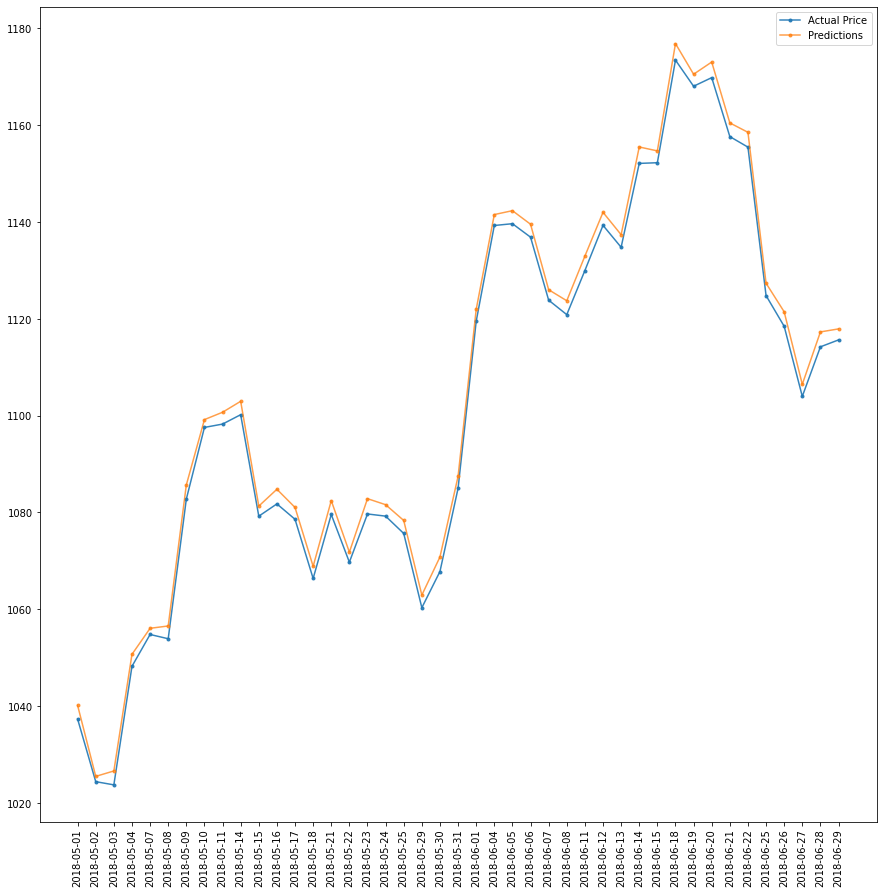

In [22]:
_ = plt.figure(figsize=(15,15))
_ = plt.plot(month['price'],  marker='.', alpha=0.9)
_ = plt.plot(month['predicted_price'], marker='.', alpha=0.75)
_ = plt.legend(['Actual Price', 'Predictions'])
_ = plt.xticks(rotation=90)
plt.show()

In [23]:
int('stop notebook execution')

ValueError: invalid literal for int() with base 10: 'stop notebook execution'

In [ ]:
def revert_data(predictions):
    
    # undo scale
    #scaler = joblib.load('../models/MinMaxScaler.save')
    #unscaled_deltas = scaler.inverse_transform(predictions)
    
    # undo log
    #inv_log = np.exp(unscaled_deltas)
    inv_log = np.exp(predictions)
    
    return inv_log
x = revert_data(predictions)
(x.min(), x.max())

In [ ]:

scaler = joblib.load('../models/MinMaxScaler.save')
unscaled_deltas = scaler.inverse_transform(predictions)
unscaled_deltas

scaler.inverse_transform([[0.81, 0.12, 3.3], [0,1, -2]])

In [ ]:
x1 = np.array([[ 0.12417709, -0.08672323,  0.88525218],[-0.12340155,  0.1822511 , -0.73470684]])
scaler.transform(x1)

In [ ]:
inv_log = np.exp(predictions)
inv_log

In [ ]:
inv_log.min(), inv_log.max()

In [ ]:
_ = plt.figure(figsize=(14,7))
_ = plt.plot(predictions, linestyle='None', marker='.')
plt.show()

In [ ]:
def get_Dense_model(input_shape):
    #initialize a sequential keras model
    model = Sequential()

    # build three layers with 100 nodes each
    model.add(Dense(100, activation='relu', input_shape=input_shape))
    model.add(Dense(100, activation='relu'))
    model.add(Dense(100, activation='relu'))

    # build final layer that will contain the output prediction
    model.add(Dense(1))

In [ ]:
def get_LSTR_model(input_shape):
    # Matt and Druv's architecture
    #initialize a sequential keras model
    model = Sequential()

    # build three layers with 100 nodes each
    model.add(LSTR(50, return_sequence=True, input_shape=input_shape))
    model.add(LSTR(50, return_sequence=True)
    model.add(LSTR(50))

    # build final layer that will contain the output prediction
    model.add(Dense(1))
    
    mode.complile(loss='mse', optimizer='adam')
    
              

In [ ]:
lr_to_test = [0.00001, 0.01, 1]
input_shape = (n_cols,)

# loop over learning rates
for lr in lr_to_test:
    model = get_new_model(input_shape)
    
    # use Stochastic Gradient Descent
    optimizer = SGD(lr=lr)
    
    model.compile(optimizer=optimizer, loss='mean_squared_error')
    
    model.fit(X_train, y_train)
    
    predictions = model.predict(X_test)
    
    mse = sum((predictions - y_test)**2)
    
    print(lr, mse)